# **ResNet50 for Knee X-Ray Classification**

In this notebook, we develop and train a ResNet50 model for binary classification of knee X-ray images

We use a [dataset](https://data.mendeley.com/datasets/fyybnjkw7v/3) from Kaggle, which provides a collection of generated knee X-ray images. The notebook will cover the data preprocessing steps, model training, and evaluation processes to assess the performance of the ResNet50 model. Additionally, we will analyze the results to understand how well the model distinguishes between different grades of osteoarthritis.

## **Data Pre-processing**



Data preprocessing is essential for preparing raw data for analysis and model training. It involves cleaning, transforming, and organizing the data to enhance model performance. Below, we detail all the preprocessing steps performed.

### **Importing Essential Libraries**




Initially, we import all the necessary libraries used throughout the notebook for analysis and model training.

In [20]:
import glob
import os
import cv2
import timeit
import numpy as np
import math
import shutil
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from operator import itemgetter
import tensorflow as tf

!pip install kaggle > /dev/null

### **Utility Functions**

We define several utility functions to facilitate data processing and model training. These functions help automate repetitive tasks and ensure code consistency throughout the notebook.

In [2]:
def countImagesByClass(path):
    class_counts = {'Negative': 0, 'Positive': 0}

    # Calculate the number of images in each class.
    class_counts['Negative'] = len(glob.glob(path + 'Negative/*.png'))
    class_counts['Positive'] = len(glob.glob(path + 'Positive/*.png'))

    return class_counts

def moveImgs(images, grade, path_dst):
  img_paths = glob.glob(f'/content/DatasetKneeKL/{grade}/*.png')
  imgs = itemgetter(*images)(img_paths)
  for img in imgs:
    #print(f'Copio {img} in {path_dst}')
    shutil.move(img, path_dst)

### **Downloading the dataset**

We download the dataset directly from Kaggle. This step involves using Kaggle’s API to download the dataset locally.

In [3]:
# Dataset download (https://www.kaggle.com/datasets/shashwatwork/knee-osteoarthritis-dataset-with-severity) https://www.kaggle.com/datasets/andymatte/bbb-synthetic-deepfake-320k
!kaggle datasets download -d andymatte/bbb-synthetic-deepfake-320k

# Creazione della cartella  e unzip del dataset in questa cartella
!mkdir -p KneeKL224
!unzip bbb-synthetic-deepfake-320k.zip -d KneeKL224 > /dev/null

# Rimozione del file.zip
!rm bbb-synthetic-deepfake-320k.zip

# Rinomino cartelle per adattarle al vecchio codice
os.rename('/content/KneeKL224/KL01_160K/', '/content/KneeKL224/Negative')
os.rename('/content/KneeKL224/KL234_160K', '/content/KneeKL224/Positive')
os.rename('/content/KneeKL224', '/content/DatasetKneeKL')

Dataset URL: https://www.kaggle.com/datasets/andymatte/bbb-synthetic-deepfake-320k
License(s): unknown
100% 8.50G/8.51G [02:02<00:00, 163MB/s]
100% 8.51G/8.51G [02:02<00:00, 74.4MB/s]


### **Dataset structure**

We examine the structure of the dataset to understand its organization and contents.



Each of these folders is divided into two class categories: KL01 and KL234. Explicit labels are not provided; instead, the KL grade of each image is inferred from the folder name in which it is located.

In [4]:
# Count the number of images in the 'Negative' and 'Positive' directories
class_counts = countImagesByClass('/content/DatasetKneeKL/')

print(f'Total dataset cardinality: {sum(class_counts.values())}')
print(f'   Negative images: {class_counts["Negative"]}')
print(f'   Positive images: {class_counts["Positive"]}')

Total dataset cardinality: 320000
   Negative images: 160000
   Positive images: 160000


### **Dataset Splitting: Train, Validation, and Test Sets**

In this section, the dataset is divided into training, validation, and test sets using functionalities provided by the *scikit-learn* library.

The dataset is split according to the following percentages:
- **Training Set**: 72% of the total dataset
- **Validation Set**: 18% of the total dataset
- **Test Set**: 10% of the total dataset


Initially, the folder structure for organizing the dataset is set up.

In [5]:
classes = ['Positive', 'Negative']
_ = [os.makedirs(f'DatasetKneeKL/{dir}/{cls}', exist_ok=True) for dir in ['train', 'val', 'test'] for cls in classes]

Indices are calculated for the initial division of the dataset into training/validation and test sets.

In [6]:
train_val_idx, test_idx = [0]*2, [0]*2
db_len = [len(glob.glob(f'/content/DatasetKneeKL/{x}/*.png')) for x in ['Positive', 'Negative']]

for i in range(2):
  train_val_idx[i], test_idx[i] = train_test_split(
      np.arange(db_len[i]), test_size=0.1, random_state=42, shuffle=True)

The distribution of images across training/validation and test sets is displayed for each Kellgren-Lawrence grade. Images are then moved to the appropriate test set directories based on the calculated indices.

In [7]:
_ = [print(f'Images {classes[i]:<8}: {db_len[i]:<8} | Training/Validation: {len(train_val_idx[i]):<8} | Test: {len(test_idx[i]):<8}') for i in range(2)]

for i, cls in enumerate(classes):
  moveImgs(test_idx[i], cls, f'/content/DatasetKneeKL/test/{cls}')

Images Positive: 160000   | Training/Validation: 144000   | Test: 16000   
Images Negative: 160000   | Training/Validation: 144000   | Test: 16000   


The indices for dividing the remaining images into training and validation sets are calculated.

In [8]:
train_idx, val_idx = [0]*2, [0]*2
db_len = [len(glob.glob(f'/content/DatasetKneeKL/{x}/*.png')) for x in ['Positive', 'Negative']]

for i in range(2):
  train_idx[i], val_idx[i] = train_test_split(
      np.arange(db_len[i]), test_size=0.15, random_state=42, shuffle=True)


As before, the cardinalities are displayed, and the images are moved to their respective directories. The original dataset directory is then removed.

In [9]:
_ = [print(f'Immagini {classes[i]:<8}: {db_len[i]:<8} | Training: {len(train_idx[i]):<8} | Validation: {len(val_idx[i]):<8}') for i in range(2)]

# Moving training images
for i, cls in enumerate(classes):
  moveImgs(train_idx[i], cls, f'/content/DatasetKneeKL/train/{cls}')

# Moving remaining validation images
for i, cls in enumerate(classes):
  moveImgs(range(len(val_idx[i])), cls, f'/content/DatasetKneeKL/val/{cls}')

Immagini Positive: 144000   | Training: 122400   | Validation: 21600   
Immagini Negative: 144000   | Training: 122400   | Validation: 21600   


In [10]:
shutil.rmtree('/content/DatasetKneeKL/Negative', ignore_errors=True)
shutil.rmtree('/content/DatasetKneeKL/Positive', ignore_errors=True)

### **Equalization**

The radiographic images in the dataset exhibited inherent limitations such as low contrast and imbalanced brightness. Histogram equalization was applied to enhance anatomical details and better highlight any potential osteoarthritis. This process used the `equalizeHist()` function from the OpenCV library after converting the images to grayscale.


In [11]:
def equalize_images(path):
    for cls in classes:
        for image_path in glob.glob(f'{path}/{cls}/*.png'):
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            equalized_image = cv2.equalizeHist(image)
            cv2.imwrite(image_path, equalized_image)

equalize_images('/content/DatasetKneeKL/train')
equalize_images('/content/DatasetKneeKL/val')
equalize_images('/content/DatasetKneeKL/test')

### **Data Augmentation**

In this section, the process of applying data augmentation is explained. This technique is used to increase the variability of the training data, helping to reduce overfitting and improve the model's generalization.

First of all, the directory paths for the training, validation, and test datasets are set up.

In [12]:
class_names = ['Positive', 'Negative']

base_dir = "/content/DatasetKneeKL/"
train_path = os.path.join(base_dir, 'train')
valid_path = os.path.join(base_dir, 'val')
test_path = os.path.join(base_dir, 'test')

The `ImageDataGenerator` is used to apply various transformations such as horizontal flipping, brightness adjustments, width shifting, and zooming to the training set images.


In [13]:
aug_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    horizontal_flip=True,
    brightness_range=[0.3, 0.8],
    width_shift_range=[-50, 0, 50, 30, -30],
    zoom_range=0.1,
    fill_mode="nearest",
)

Additionally, a separate `ImageDataGenerator` is set up without augmentation for the validation and test set, applying only the necessary preprocessing.

In [14]:
noaug_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
)

Then, the data generators are set up.


In [15]:
target_size = (224, 224)

train_generator = aug_datagen.flow_from_directory(
    train_path, class_mode="categorical", target_size=target_size, shuffle=True
)

valid_generator = noaug_datagen.flow_from_directory(
    valid_path,
    class_mode="categorical",
    target_size=target_size,
    shuffle=False,
)

test_generator = noaug_datagen.flow_from_directory(
    test_path,
    class_mode="categorical",
    target_size=target_size,
    shuffle=False,
)

Found 244800 images belonging to 2 classes.
Found 43200 images belonging to 2 classes.
Found 32000 images belonging to 2 classes.


## **Model Training**

In this section, a neural network model is configured and trained using TensorFlow and Keras. The model is based on a pre-trained ResNet50, with modifications made for the specific classification task.

First of all, the ResNet50 is loaded without weights and configured for fine-tuning.

In [16]:
epochs = 5
img_shape = (224, 120, 3)

model = tf.keras.applications.ResNet50(
    input_shape=(img_shape),
    include_top=False,
    weights=None,
)

Then, all layers of the pre-trained ResNet50 model are set to be trainable. A new model is created by stacking the ResNet50 base with additional layers, including global average pooling, dropout for regularization, and a dense output layer with softmax activation for classification. The model architecture is then summarized.


In [17]:
for layer in model.layers:
    layer.trainable = True

model_ft = tf.keras.models.Sequential(
    [
        model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(2, activation="softmax"),
    ]
)

model_ft.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 4, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 2)                 4098      
                                                                 
Total params: 23591810 (90.00 MB)
Trainable params: 23538690 (89.79 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


The model is compiled using the **Adam** optimizer with a learning rate of **0.0001**, and the **binary crossentropy** loss function.


In [18]:
model_ft.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"]
)

Setting the *batch_size*.

In [21]:
batch_size = 92

total_train_samples = train_generator.samples
total_valid_samples = valid_generator.samples

steps_per_epoch = math.ceil(total_train_samples / batch_size)
validation_steps = math.ceil(total_valid_samples / batch_size)


Google Drive is mounted, and a callback is set up to save model weights for each epochs.

In [ ]:
from google.colab import drive
from keras.callbacks import LambdaCallback

# Monta Google Drive
drive.mount('/content/drive')

weights_dir = "/content/drive/MyDrive/model_weights"
os.makedirs(weights_dir, exist_ok=True)

save_model_callback = LambdaCallback(
    on_epoch_end=lambda epoch, logs: model_ft.save(os.path.join(weights_dir, f"320k_ResNet50_Binario_Epoch_{epoch+1}.h5"))
)


Finally, the model is trained.


In [ ]:

start_ft = timeit.default_timer()

history = model_ft.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[save_model_callback],
    validation_data=valid_generator,
    validation_steps=validation_steps,
    verbose=1,
)

stop_ft = timeit.default_timer()

Epoch 1/5
2661/2661 [==============================] - ETA: 0s - loss: 0.2903 - accuracy: 0.8698

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2661/2661 [==============================] - 1856s 680ms/step - loss: 0.2903 - accuracy: 0.8698 - val_loss: 7.9316 - val_accuracy: 0.0249
Epoch 2/5
2661/2661 [==============================] - 1813s 681ms/step - loss: 0.0757 - accuracy: 0.9716 - val_loss: 1.8608 - val_accuracy: 0.5389
Epoch 3/5
2661/2661 [==============================] - 1752s 658ms/step - loss: 0.0419 - accuracy: 0.9845 - val_loss: 0.0251 - val_accuracy: 0.9912
Epoch 4/5
2661/2661 [==============================] - 1722s 647ms/step - loss: 0.0281 - accuracy: 0.9901 - val_loss: 0.0011 - val_accuracy: 0.9996
Epoch 5/5
2661/2661 [==============================] - 1696s 637ms/step - loss: 0.0204 - accuracy: 0.9929 - val_loss: 0.0195 - val_accuracy: 0.9930


In [ ]:
execution_time_ft = (stop_ft - start_ft) / 60
print(
    f"Model ResNet50 fine tuning executed in {execution_time_ft:.2f} minutes"
)

Model ResNet50 fine tuning executed in 148.37 minutes


## **Evaluation and Results**

In this section, the performance of the ResNet50 model is evaluated using various metrics. This includes analyzing training and validation loss and accuracy curves, test set accuracy, precision, recall, F1-score, and the confusion matrix.


The utility functions used for performance evaluation are listed below.

In [ ]:
import seaborn as sns
from sklearn.metrics import (accuracy_score, balanced_accuracy_score,
                             classification_report, confusion_matrix)

def get_plot_loss_acc(model, model_name):
    fig = plt.figure()
    plt.subplot(2, 1, 1)
    plt.plot(model.history.history["loss"])
    plt.plot(model.history.history["val_loss"])
    plt.title(f"{model_name} \n\n model loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train", "valid"], loc="upper right")

    plt.subplot(2, 1, 2)
    plt.plot(model.history.history["accuracy"])
    plt.plot(model.history.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "valid"], loc="lower right")

    plt.tight_layout()

def get_evaluate(data, name, model):
    score_model = model.evaluate(data, verbose=1)
    print(f"{name} loss: {score_model[0]:.6f}")
    print(f"{name} accuracy: {score_model[1]:.6f}")

def get_formatted_classification_report(y_true, y_pred, target_names, decimal_places=5):
    report = classification_report(y_true, y_pred, target_names=target_names, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    report_df = report_df.applymap(lambda x: f"{x:.{decimal_places}f}" if isinstance(x, (float, np.float64)) else x)

    print(report_df.to_string(index=False))

    return report_df

def compute_confusion_matrix(ytrue, ypred, class_names, model_name):
    cm = confusion_matrix(
        y_true=ytrue.labels,
        y_pred=np.argmax(ypred, axis=1),
    )

    cmn = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    plt.subplots(figsize=(10, 8))
    sns.heatmap(
        cmn,
        annot=True,
        fmt=".5f",
        cmap="Purples",
        xticklabels=class_names,
        yticklabels=class_names,
    )
    plt.title(f"Confusion Matrix - {model_name}")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show(block=False)

def get_predict(data, model):
    predict_model = model.predict(data)
    return predict_model

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    heatmap = np.uint8(255 * heatmap)

    jet = mpl.colormaps["jet"]
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    superimposed_img.save(cam_path)

    plt.figure(figsize=(10, 10))
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.show()

def get_img_array(img_path, size):
    img = keras.utils.load_img(img_path, target_size=size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    resnet_model = model.get_layer('resnet50')
    last_conv_layer = resnet_model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.models.Model(resnet_model.input, last_conv_layer.output)

    classifier_input = keras.layers.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer in model.layers[1:]:
        x = layer(x)
    classifier_model = keras.models.Model(classifier_input, x)

    with tf.GradientTape() as tape:
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        preds = classifier_model(last_conv_layer_output)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


Loading the model.

In [ ]:
from tensorflow.keras.models import load_model
model = load_model("/content/drive/MyDrive/DiElle/NOTEBOOK FINALI/BINARIO_320k/BINARIO_320k.h5")

### **Training and Validation Loss and Accuracy Plots**

Below, the loss and accuracy graphs for the training and validation sets are shown.

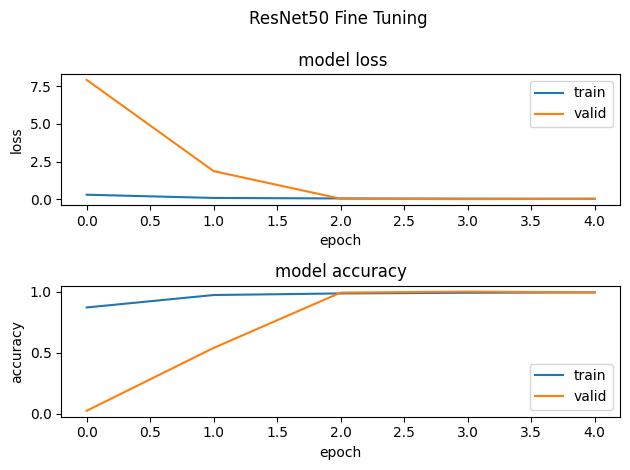

In [ ]:
get_plot_loss_acc(model_ft, f"ResNet50 Fine Tuning")

### **Test Accuracy**

Below, the test accuracy of the model is shown.

In [ ]:
get_evaluate(test_generator, "Test", model)

1000/1000 [==============================] - 116s 115ms/step - loss: 0.0020 - accuracy: 0.9994
Test loss: 0.00196
Test accuracy: 0.99937


### **Precision, Recall and F1-score**

Below, the precision, recall, and F1 score metrics for the model are shown.

In [ ]:
# Model predictions
y_pred_proba = get_predict(test_generator, model)
y_pred = np.argmax(y_pred_proba, axis=1)

get_formatted_classification_report(test_generator.labels, y_pred, class_names, decimal_places=5)

precision  recall f1-score     support
  0.99900 0.99975  0.99938 16000.00000
  0.99975 0.99900  0.99937 16000.00000
  0.99938 0.99938  0.99938     0.99938
  0.99938 0.99938  0.99937 32000.00000
  0.99938 0.99938  0.99937 32000.00000


,precision,recall,f1-score,support
Positive,0.99900,0.99975,0.99938,16000.00000
Negative,0.99975,0.99900,0.99937,16000.00000
accuracy,0.99938,0.99938,0.99938,0.99938
macro avg,0.99938,0.99938,0.99937,32000.00000
weighted avg,0.99938,0.99938,0.99937,32000.00000


from matplotlib import pyplot as plt
import seaborn as sns
_df_0.groupby('precision').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_1.groupby('recall').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_2.groupby('f1-score').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_3.groupby('support').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['recall'].value_counts()
    for x_label, grp in _df_4.groupby('precision')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('precision')
_ = plt.ylabel('recall')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['f1-score'].value_counts()
    for x_label, grp in _df_5.groupby('recall')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('recall')
_ = plt.ylabel('f1-score')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['support'].value_counts()
    for x_label, grp in _df_6.groupby('f1-score')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('f1-score')
_ = plt.ylabel('support')

### **Confusion Matrix**


Below are the two confusion matrices, shown both as percentages and in absolute values.

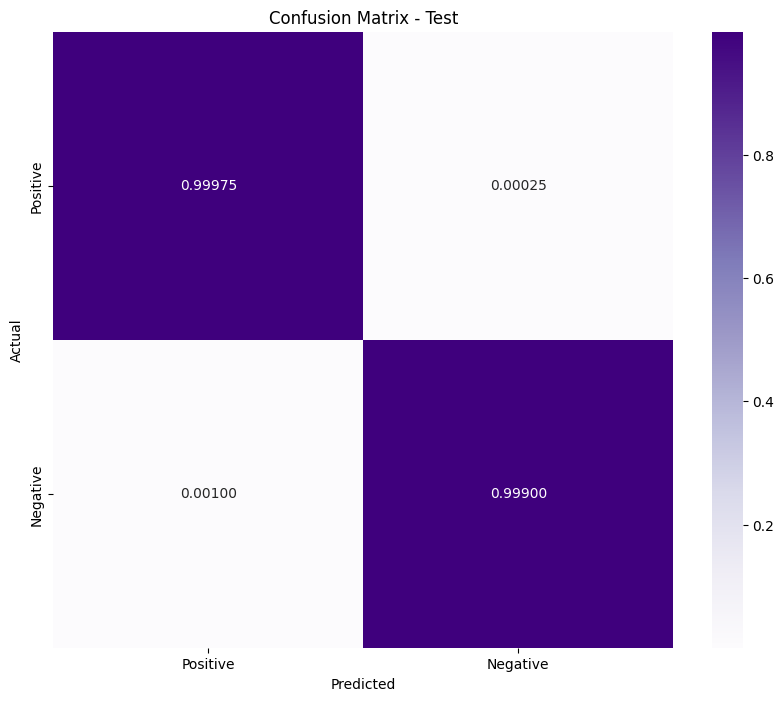

In [ ]:
compute_confusion_matrix(test_generator, y_pred_proba, class_names, "Test")

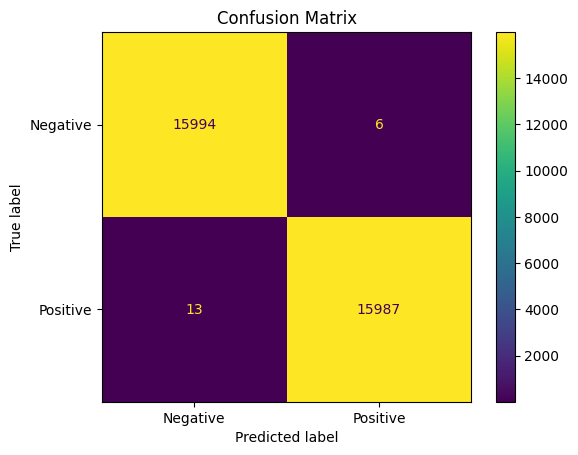

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate confusion matrix
cm = confusion_matrix(test_generator.labels, y_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=["Negative", "Positive"])

# Display confusion matrix
cmd.plot()
plt.title('Confusion Matrix')
plt.show()

### **Grad-CAM**

Below, the Grad-CAM application on a test set image of the Positive class is shown.

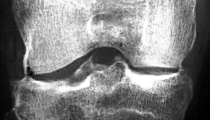

1/1 [==============================] - 0s 42ms/step
Predicted: Positive with confidence 1.00


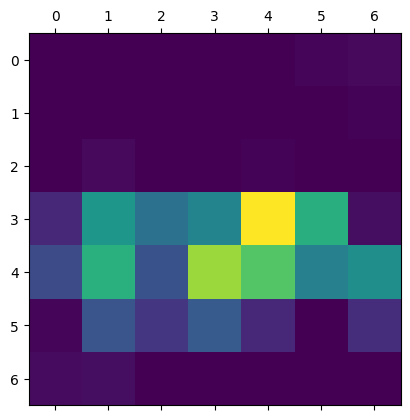

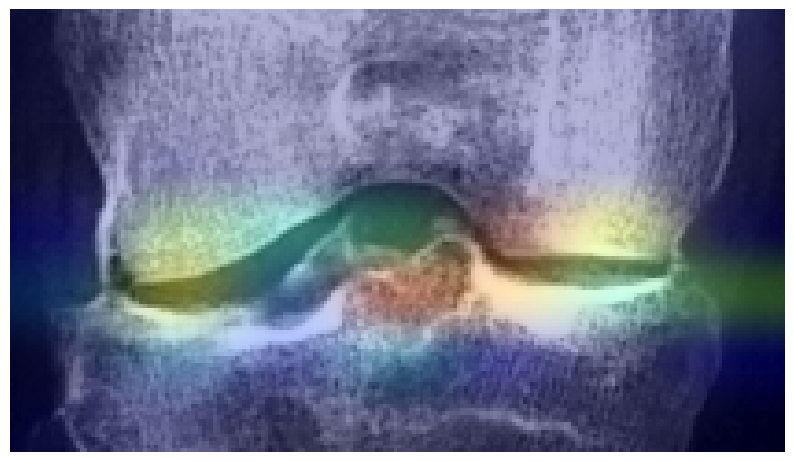

In [ ]:
from IPython.display import Image, display

img_size = (224, 224)

# Load ResNet50 preprocessing and decoding functions
preprocess_input = tf.keras.applications.resnet50.preprocess_input
decode_predictions = tf.keras.applications.resnet50.decode_predictions
last_conv_layer_name = "conv5_block3_out"

# Define the path to test images and select a random image
test_dir = "/content/KneeKL/test/Positive"
img_list = glob.glob(test_dir + "/*.png")
img_path = random.choice(img_list)

# Read and preprocess the image
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
equalized_img = cv2.equalizeHist(img)

# Save the processed image and display it
cv2.imwrite(img_path, equalized_img)
display(Image(img_path))

# Preprocess the input image and make predictions
img_array = preprocess_input(get_img_array(img_path, size=img_size))
preds = model.predict(img_array)
class_labels = ['Negative', 'Positive']
predicted_class = class_labels[np.argmax(preds)]

# Display the predicted class and confidence
print(f"Predicted: {predicted_class} with confidence {np.max(preds):.2f}")

# Generate and display the Grad-CAM heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
plt.matshow(heatmap)
plt.show()

save_and_display_gradcam(img_path, heatmap)